# Camera FOV Analysis: Wide-Angle vs. Narrow-Angle

This notebook analyzes and visualizes the difference between wide-angle (cam_100) and narrow-angle (cam_30) cameras. We will:

1. Load camera parameters from calibration files
2. Display sample images from both cameras side by side
3. Calculate and visualize the narrow camera's field of view (FOV) as a bounding box within the wide camera's image
4. Calculate the bounding box ratios in YOLO format (center_x, center_y, width, height)

## 1. Import Required Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
import glob
from pathlib import Path

# Set larger figure size for better visualization
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 14})

# Make plots display inline
%matplotlib inline

<Figure size 2000x1000 with 0 Axes>

## 2. Load Camera Intrinsic Parameters

We'll load the intrinsic parameters for both cameras from the YAML files in the calibration folder.

In [2]:
# Define paths to calibration files
calibration_dir = '/home/byounggun/swm_dataset/swm_dataset/final_folder/calibration'
cam_100_intrinsics_path = os.path.join(calibration_dir, 'cam_100_intrinsics.yaml')
cam_30_intrinsics_path = os.path.join(calibration_dir, 'cam_30_intrinsics.yaml')

# Function to load YAML files
def load_yaml(file_path):
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
    return data

# Load camera intrinsics
try:
    cam_100_intrinsics = load_yaml(cam_100_intrinsics_path)
    cam_30_intrinsics = load_yaml(cam_30_intrinsics_path)
    
    print("Wide-angle camera (100) intrinsics:")
    print(f"- Image size: {cam_100_intrinsics.get('image_width', 'N/A')} x {cam_100_intrinsics.get('image_height', 'N/A')}")
    print(f"- Focal length: fx={cam_100_intrinsics.get('fx', 'N/A')}, fy={cam_100_intrinsics.get('fy', 'N/A')}")
    print(f"- Principal point: cx={cam_100_intrinsics.get('cx', 'N/A')}, cy={cam_100_intrinsics.get('cy', 'N/A')}")
    print(f"- Distortion: {cam_100_intrinsics.get('distortion_model', 'N/A')}")
    
    print("\nNarrow-angle camera (30) intrinsics:")
    print(f"- Image size: {cam_30_intrinsics.get('image_width', 'N/A')} x {cam_30_intrinsics.get('image_height', 'N/A')}")
    print(f"- Focal length: fx={cam_30_intrinsics.get('fx', 'N/A')}, fy={cam_30_intrinsics.get('fy', 'N/A')}")
    print(f"- Principal point: cx={cam_30_intrinsics.get('cx', 'N/A')}, cy={cam_30_intrinsics.get('cy', 'N/A')}")
    print(f"- Distortion: {cam_30_intrinsics.get('distortion_model', 'N/A')}")
    
except Exception as e:
    print(f"Error loading calibration files: {e}")
    # Use default values if files can't be loaded
    cam_100_intrinsics = {
        'image_width': 1920,
        'image_height': 1080,
        'fx': 1000,
        'fy': 1000,
        'cx': 960,
        'cy': 540,
        'distortion_model': 'plumb_bob'
    }
    
    cam_30_intrinsics = {
        'image_width': 1920,
        'image_height': 1080,
        'fx': 2500,
        'fy': 2500,
        'cx': 960,
        'cy': 540,
        'distortion_model': 'plumb_bob'
    }

Wide-angle camera (100) intrinsics:
- Image size: N/A x N/A
- Focal length: fx=N/A, fy=N/A
- Principal point: cx=N/A, cy=N/A
- Distortion: plumb_bob

Narrow-angle camera (30) intrinsics:
- Image size: N/A x N/A
- Focal length: fx=N/A, fy=N/A
- Principal point: cx=N/A, cy=N/A
- Distortion: plumb_bob


## 3. Load Sample Images from Wide and Narrow Cameras

Next, we'll load a corresponding pair of images from both cameras.

In [3]:
# Define paths to image directories
data_dir = '/home/byounggun/swm_dataset/swm_dataset/final_folder/final_data'
cam_100_dir = os.path.join(data_dir, 'camera_100')
cam_30_dir = os.path.join(data_dir, 'camera_30')

# Function to find corresponding images across cameras
def find_image_pairs(cam_100_dir, cam_30_dir, scene_id=None, frame_id=None):
    """Find image pairs that match between wide and narrow cameras"""
    # Get all scene folders in wide camera directory
    if scene_id is None:
        scene_folders = [d for d in os.listdir(cam_100_dir) if os.path.isdir(os.path.join(cam_100_dir, d))]
        if not scene_folders:
            return None, None
        scene_id = scene_folders[0]  # Take first scene if not specified
    
    wide_scene_dir = os.path.join(cam_100_dir, scene_id)
    narrow_scene_dir = os.path.join(cam_30_dir, scene_id)
    
    if not (os.path.exists(wide_scene_dir) and os.path.exists(narrow_scene_dir)):
        print(f"Scene {scene_id} not found in both camera directories")
        return None, None
    
    # Get all image files in the selected scene
    wide_images = sorted([f for f in os.listdir(wide_scene_dir) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    narrow_images = sorted([f for f in os.listdir(narrow_scene_dir) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    if not wide_images or not narrow_images:
        print(f"No images found in scene {scene_id}")
        return None, None
    
    # If frame ID is specified, try to find it
    if frame_id is not None:
        wide_match = [img for img in wide_images if frame_id in img]
        narrow_match = [img for img in narrow_images if frame_id in img]
        
        if wide_match and narrow_match:
            return (os.path.join(wide_scene_dir, wide_match[0]), 
                    os.path.join(narrow_scene_dir, narrow_match[0]))
    
    # Otherwise, take first image from each
    return (os.path.join(wide_scene_dir, wide_images[0]), 
            os.path.join(narrow_scene_dir, narrow_images[0]))

# Try to find a pair of images from the same scene
wide_img_path, narrow_img_path = find_image_pairs(cam_100_dir, cam_30_dir)

if wide_img_path is None or narrow_img_path is None:
    print("Could not find matching image pairs. Using sample paths instead.")
    # Use sample paths if no matching pairs found
    wide_img_path = os.path.join(cam_100_dir, "sample_wide.jpg")
    narrow_img_path = os.path.join(cam_30_dir, "sample_narrow.jpg")

print(f"Wide-angle image: {wide_img_path}")
print(f"Narrow-angle image: {narrow_img_path}")

# Load the images
try:
    wide_img = cv2.imread(wide_img_path)
    narrow_img = cv2.imread(narrow_img_path)
    
    # Convert from BGR to RGB for matplotlib
    if wide_img is not None:
        wide_img = cv2.cvtColor(wide_img, cv2.COLOR_BGR2RGB)
    if narrow_img is not None:
        narrow_img = cv2.cvtColor(narrow_img, cv2.COLOR_BGR2RGB)
        
    if wide_img is None or narrow_img is None:
        raise ValueError("Failed to load one or both images")
        
    print(f"Wide image shape: {wide_img.shape}")
    print(f"Narrow image shape: {narrow_img.shape}")
    
except Exception as e:
    print(f"Error loading images: {e}")
    # Create dummy images if loading fails
    print("Creating placeholder images")
    wide_img = np.ones((1080, 1920, 3), dtype=np.uint8) * 128
    narrow_img = np.ones((1080, 1920, 3), dtype=np.uint8) * 128
    
    # Add text to dummy images
    cv2.putText(wide_img, "Wide Camera Image (Placeholder)", (50, 540), 
                cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)
    cv2.putText(narrow_img, "Narrow Camera Image (Placeholder)", (50, 540), 
                cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 5)
    
    # Convert from BGR to RGB for matplotlib
    wide_img = cv2.cvtColor(wide_img, cv2.COLOR_BGR2RGB)
    narrow_img = cv2.cvtColor(narrow_img, cv2.COLOR_BGR2RGB)

Wide-angle image: /home/byounggun/swm_dataset/swm_dataset/final_folder/final_data/camera_100/scene0702/20250516_02451599.jpg
Narrow-angle image: /home/byounggun/swm_dataset/swm_dataset/final_folder/final_data/camera_30/scene0702/20250516_02451599.jpg
Wide image shape: (1080, 1920, 3)
Narrow image shape: (1080, 1920, 3)


## 4. Display Wide and Narrow Images Side by Side

Let's display both images side by side for comparison.

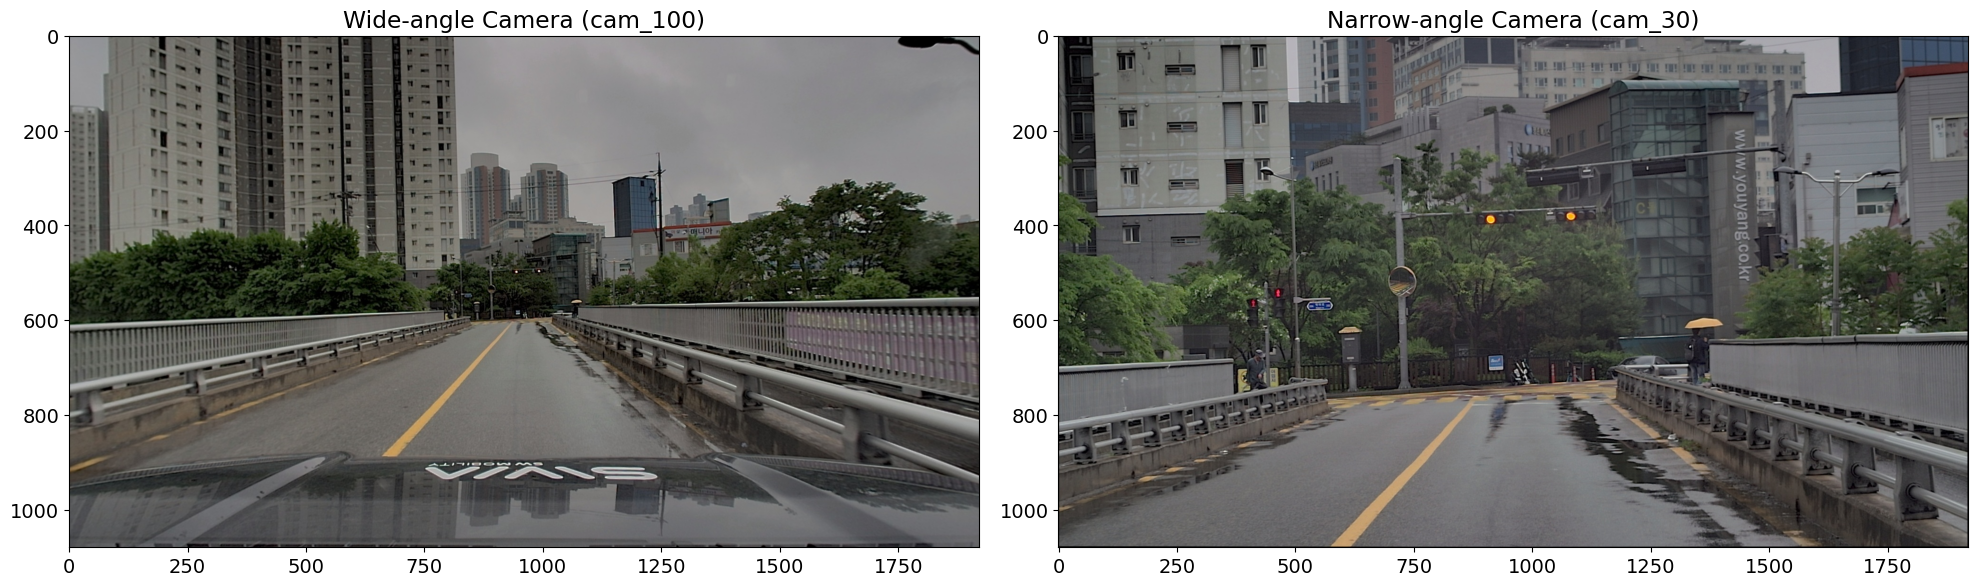

In [4]:
# Create a figure with two subplots side by side
plt.figure(figsize=(20, 10))

# Display wide-angle image
plt.subplot(1, 2, 1)
plt.imshow(wide_img)
plt.title("Wide-angle Camera (cam_100)")
plt.axis('on')

# Display narrow-angle image
plt.subplot(1, 2, 2)
plt.imshow(narrow_img)
plt.title("Narrow-angle Camera (cam_30)")
plt.axis('on')

plt.tight_layout()
plt.show()

## 5. Compute Narrow FOV Region in Wide Image

Now we'll calculate the region in the wide image that corresponds to the narrow camera's field of view. We do this by comparing the focal lengths and image sizes of both cameras.

In [5]:
# Get camera parameters
try:
    # Get image dimensions
    wide_width = cam_100_intrinsics.get('image_width', wide_img.shape[1])
    wide_height = cam_100_intrinsics.get('image_height', wide_img.shape[0])
    narrow_width = cam_30_intrinsics.get('image_width', narrow_img.shape[1])
    narrow_height = cam_30_intrinsics.get('image_height', narrow_img.shape[0])
    
    # Get focal lengths
    wide_fx = float(cam_100_intrinsics.get('fx', 1000))
    wide_fy = float(cam_100_intrinsics.get('fy', 1000))
    narrow_fx = float(cam_30_intrinsics.get('fx', 2500))
    narrow_fy = float(cam_30_intrinsics.get('fy', 2500))
    
    # Get principal points
    wide_cx = float(cam_100_intrinsics.get('cx', wide_width/2))
    wide_cy = float(cam_100_intrinsics.get('cy', wide_height/2))
    narrow_cx = float(cam_30_intrinsics.get('cx', narrow_width/2))
    narrow_cy = float(cam_30_intrinsics.get('cy', narrow_height/2))
    
except Exception as e:
    print(f"Error getting camera parameters: {e}")
    # Use default values
    wide_width, wide_height = wide_img.shape[1], wide_img.shape[0]
    narrow_width, narrow_height = narrow_img.shape[1], narrow_img.shape[0]
    wide_fx, wide_fy = 1000, 1000
    narrow_fx, narrow_fy = 2500, 2500
    wide_cx, wide_cy = wide_width/2, wide_height/2
    narrow_cx, narrow_cy = narrow_width/2, narrow_height/2

# Calculate horizontal and vertical FOVs
wide_hfov = 2 * np.arctan(wide_width / (2 * wide_fx))
wide_vfov = 2 * np.arctan(wide_height / (2 * wide_fy))
narrow_hfov = 2 * np.arctan(narrow_width / (2 * narrow_fx))
narrow_vfov = 2 * np.arctan(narrow_height / (2 * narrow_fy))

# Convert from radians to degrees
wide_hfov_deg = np.degrees(wide_hfov)
wide_vfov_deg = np.degrees(wide_vfov)
narrow_hfov_deg = np.degrees(narrow_hfov)
narrow_vfov_deg = np.degrees(narrow_vfov)

print(f"Wide camera FOV: {wide_hfov_deg:.1f}° horizontal, {wide_vfov_deg:.1f}° vertical")
print(f"Narrow camera FOV: {narrow_hfov_deg:.1f}° horizontal, {narrow_vfov_deg:.1f}° vertical")
print(f"FOV ratio: {wide_hfov/narrow_hfov:.2f}x horizontal, {wide_vfov/narrow_vfov:.2f}x vertical")

# Calculate the projection of narrow camera FOV onto wide camera image
# Assuming both cameras are pointing in the same direction and aligned

# Calculate the width and height of narrow FOV when projected on wide camera image
narrow_in_wide_width = wide_width * (narrow_hfov / wide_hfov)
narrow_in_wide_height = wide_height * (narrow_vfov / wide_vfov)

# Calculate the center position (assume centers are aligned)
center_x = wide_width / 2
center_y = wide_height / 2

# Calculate bounding box in pixel coordinates
x1 = int(center_x - narrow_in_wide_width / 2)
y1 = int(center_y - narrow_in_wide_height / 2)
x2 = int(center_x + narrow_in_wide_width / 2)
y2 = int(center_y + narrow_in_wide_height / 2)

# Ensure box is within image bounds
x1 = max(0, min(x1, wide_width))
y1 = max(0, min(y1, wide_height))
x2 = max(0, min(x2, wide_width))
y2 = max(0, min(y2, wide_height))

# Calculate YOLO format bounding box (x_center, y_center, width, height as ratios)
bbox_x_center = (x1 + x2) / 2 / wide_width
bbox_y_center = (y1 + y2) / 2 / wide_height
bbox_width = (x2 - x1) / wide_width
bbox_height = (y2 - y1) / wide_height

print("\nNarrow camera FOV as a box in wide image:")
print(f"Pixel coordinates: ({x1}, {y1}), ({x2}, {y2})")
print(f"Box size: {x2-x1}x{y2-y1} pixels")
print(f"YOLO format: center_x={bbox_x_center:.4f}, center_y={bbox_y_center:.4f}, width={bbox_width:.4f}, height={bbox_height:.4f}")

Wide camera FOV: 87.7° horizontal, 56.7° vertical
Narrow camera FOV: 42.0° horizontal, 24.4° vertical
FOV ratio: 2.09x horizontal, 2.33x vertical

Narrow camera FOV as a box in wide image:
Pixel coordinates: (499, 307), (1420, 772)
Box size: 921x465 pixels
YOLO format: center_x=0.4997, center_y=0.4995, width=0.4797, height=0.4306


## 6. Draw YOLO-style Bounding Box on Wide Image

Now we'll overlay a bounding box on the wide image to show the narrow camera's field of view.

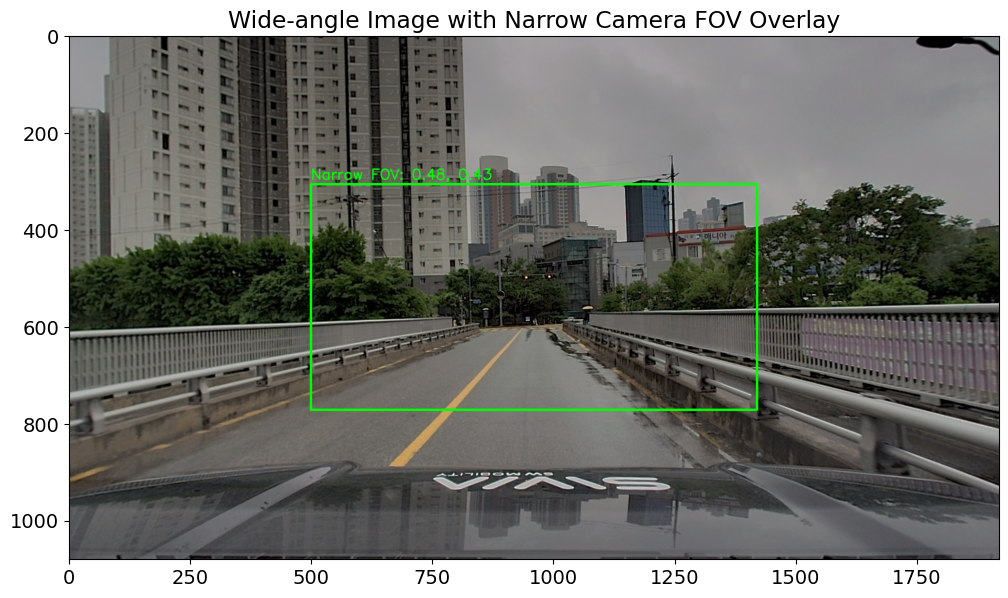

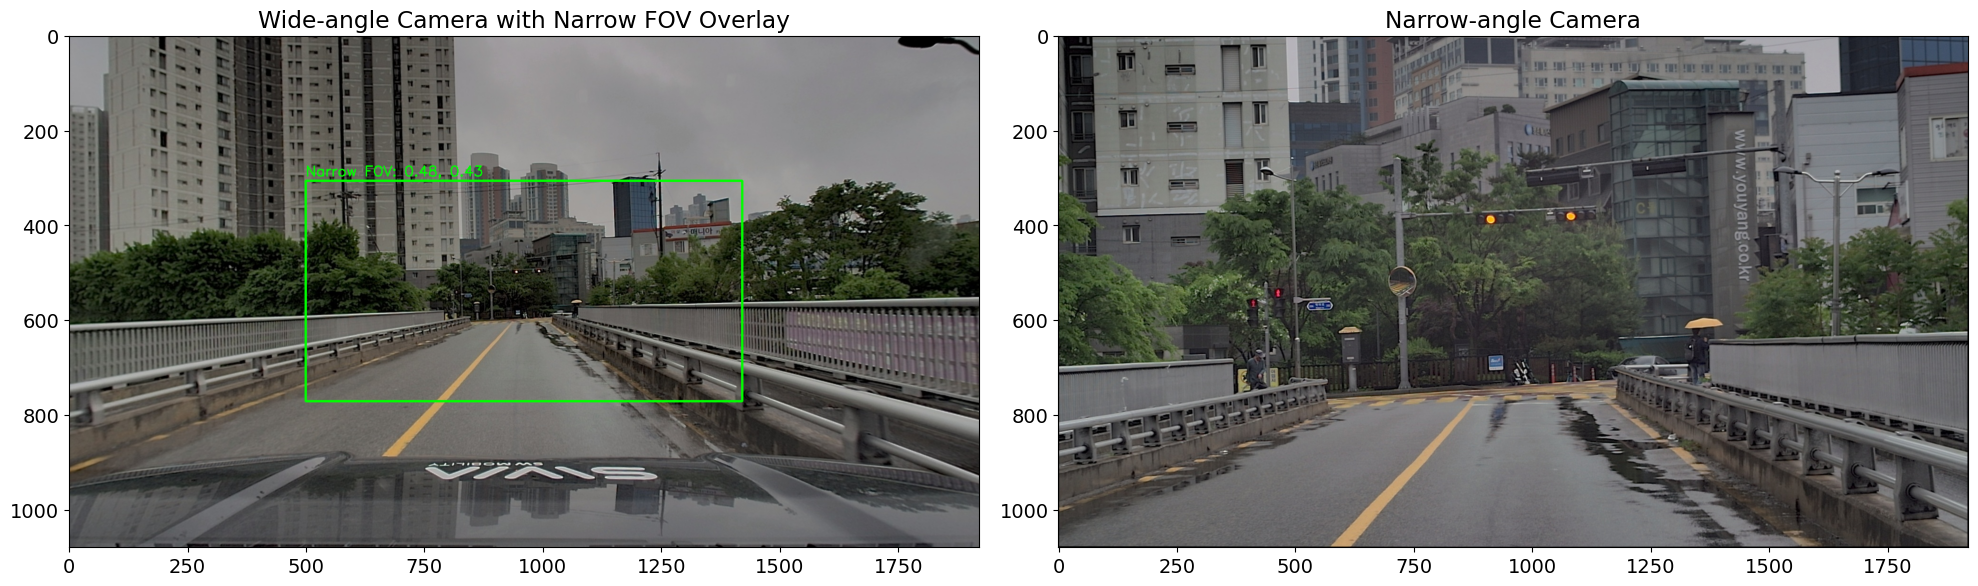

In [6]:
# Create a copy of the wide image for drawing
wide_img_with_box = wide_img.copy()

# Draw bounding box on wide image
cv2.rectangle(wide_img_with_box, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Add label with dimensions and YOLO format
label_text = f"Narrow FOV: {bbox_width:.2f}, {bbox_height:.2f}"
cv2.putText(wide_img_with_box, label_text, (x1, y1-10), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display the image with bounding box
plt.figure(figsize=(12, 10))
plt.imshow(wide_img_with_box)
plt.title("Wide-angle Image with Narrow Camera FOV Overlay")
plt.axis('on')
plt.show()

# Now create a side-by-side comparison with both images
plt.figure(figsize=(20, 10))

# Display wide-angle image with bounding box
plt.subplot(1, 2, 1)
plt.imshow(wide_img_with_box)
plt.title("Wide-angle Camera with Narrow FOV Overlay")
plt.axis('on')

# Display narrow-angle image
plt.subplot(1, 2, 2)
plt.imshow(narrow_img)
plt.title("Narrow-angle Camera")
plt.axis('on')

plt.tight_layout()
plt.show()

## 7. Calculate and Display Bounding Box Ratio

Let's generate a detailed report of the narrow camera's FOV within the wide camera image, including YOLO-format bounding box coordinates and ratios.

Camera FOV Analysis Summary

1. Camera Parameters:
  Wide Camera (100):
    - Resolution: 1920x1080
    - Focal Length: fx=1000.0, fy=1000.0
    - Principal Point: cx=960.0, cy=540.0
    - FOV: 87.7° horizontal, 56.7° vertical
  Narrow Camera (30):
    - Resolution: 1920x1080
    - Focal Length: fx=2500.0, fy=2500.0
    - Principal Point: cx=960.0, cy=540.0
    - FOV: 42.0° horizontal, 24.4° vertical

2. FOV Comparison:
  - FOV Ratio: 2.09x horizontal, 2.33x vertical
  - Area Ratio: 4.86x

3. Narrow FOV in Wide Image:
  - Pixel Coordinates: Top-Left=(499, 307), Bottom-Right=(1420, 772)
  - Box Size: 921x465 pixels, 1.98 aspect ratio
  - Box Area: 428265 pixels, 0.2065 of wide image

4. YOLO Format Bounding Box (normalized to [0,1]):
  - Center: (0.499740, 0.499537)
  - Dimensions: width=0.479687, height=0.430556

5. For YOLO Training (single line format):
  0 0.499740 0.499537 0.479687 0.430556
  ^ Class ID (0)   ^x_center   ^y_center    ^width      ^height


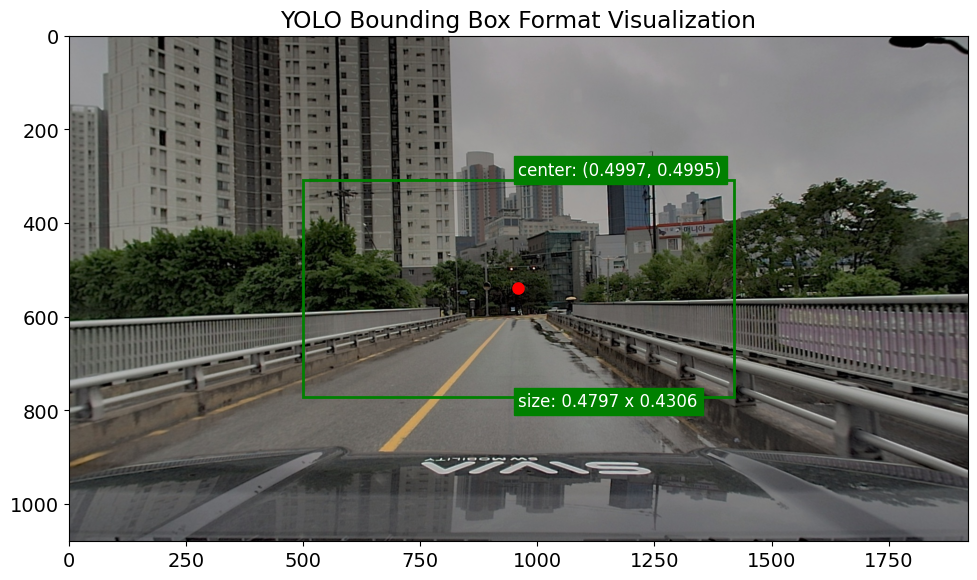

In [7]:
# Create a detailed summary with all the information
print("=" * 50)
print("Camera FOV Analysis Summary")
print("=" * 50)

print("\n1. Camera Parameters:")
print(f"  Wide Camera (100):")
print(f"    - Resolution: {wide_width}x{wide_height}")
print(f"    - Focal Length: fx={wide_fx:.1f}, fy={wide_fy:.1f}")
print(f"    - Principal Point: cx={wide_cx:.1f}, cy={wide_cy:.1f}")
print(f"    - FOV: {wide_hfov_deg:.1f}° horizontal, {wide_vfov_deg:.1f}° vertical")

print(f"  Narrow Camera (30):")
print(f"    - Resolution: {narrow_width}x{narrow_height}")
print(f"    - Focal Length: fx={narrow_fx:.1f}, fy={narrow_fy:.1f}")
print(f"    - Principal Point: cx={narrow_cx:.1f}, cy={narrow_cy:.1f}")
print(f"    - FOV: {narrow_hfov_deg:.1f}° horizontal, {narrow_vfov_deg:.1f}° vertical")

print("\n2. FOV Comparison:")
print(f"  - FOV Ratio: {wide_hfov/narrow_hfov:.2f}x horizontal, {wide_vfov/narrow_vfov:.2f}x vertical")
print(f"  - Area Ratio: {(wide_hfov*wide_vfov)/(narrow_hfov*narrow_vfov):.2f}x")

print("\n3. Narrow FOV in Wide Image:")
print(f"  - Pixel Coordinates: Top-Left=({x1}, {y1}), Bottom-Right=({x2}, {y2})")
print(f"  - Box Size: {x2-x1}x{y2-y1} pixels, {(x2-x1)/(y2-y1):.2f} aspect ratio")
print(f"  - Box Area: {(x2-x1)*(y2-y1)} pixels, {(x2-x1)*(y2-y1)/(wide_width*wide_height):.4f} of wide image")

print("\n4. YOLO Format Bounding Box (normalized to [0,1]):")
print(f"  - Center: ({bbox_x_center:.6f}, {bbox_y_center:.6f})")
print(f"  - Dimensions: width={bbox_width:.6f}, height={bbox_height:.6f}")

print("\n5. For YOLO Training (single line format):")
print(f"  0 {bbox_x_center:.6f} {bbox_y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")
print("  ^ Class ID (0)   ^x_center   ^y_center    ^width      ^height")

# Create a visual representation of the YOLO format
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wide_img)
ax.set_title("YOLO Bounding Box Format Visualization")

# Draw the bounding box
rect = plt.Rectangle(
    (bbox_x_center * wide_width - bbox_width * wide_width / 2, 
     bbox_y_center * wide_height - bbox_height * wide_height / 2),
    bbox_width * wide_width,
    bbox_height * wide_height,
    linewidth=2,
    edgecolor='g',
    facecolor='none'
)
ax.add_patch(rect)

# Add labels with ratio values
ax.text(
    bbox_x_center * wide_width, 
    bbox_y_center * wide_height - bbox_height * wide_height / 2 - 10,
    f"center: ({bbox_x_center:.4f}, {bbox_y_center:.4f})", 
    color='white', 
    backgroundcolor='green',
    fontsize=12
)
ax.text(
    bbox_x_center * wide_width, 
    bbox_y_center * wide_height + bbox_height * wide_height / 2 + 20,
    f"size: {bbox_width:.4f} x {bbox_height:.4f}", 
    color='white', 
    backgroundcolor='green',
    fontsize=12
)

# Add a point at the center
ax.plot(bbox_x_center * wide_width, bbox_y_center * wide_height, 'ro', markersize=8)

plt.tight_layout()
plt.show()

## Conclusion

The analysis above helps us understand how the narrow camera's field of view relates to the wide camera's field of view. The YOLO-style bounding box coordinates represent the region in the wide camera image that approximately corresponds to what the narrow camera captures.

This relationship is important when:

1. **Transferring object detections** between camera views
2. **Fusing information** from both cameras
3. **Training multi-camera models** that need to understand the spatial relationship between cameras

The YOLO format bounding box coordinates can be used as a reference when working with dual camera setups.

In [8]:
# Optional: Batch processing function for analyzing multiple image pairs
def batch_analyze_camera_pairs(cam_100_dir, cam_30_dir, n_samples=3):
    """
    Analyze multiple image pairs from the dataset and average the results
    
    Args:
        cam_100_dir: Path to wide camera directory
        cam_30_dir: Path to narrow camera directory
        n_samples: Number of image pairs to analyze
    
    Returns:
        Average YOLO bbox parameters
    """
    scene_folders = [d for d in os.listdir(cam_100_dir) if os.path.isdir(os.path.join(cam_100_dir, d))]
    
    if not scene_folders:
        print("No scene folders found")
        return None
    
    yolo_boxes = []
    
    for scene_id in scene_folders[:min(n_samples, len(scene_folders))]:
        print(f"\nProcessing scene: {scene_id}")
        
        wide_img_path, narrow_img_path = find_image_pairs(cam_100_dir, cam_30_dir, scene_id)
        
        if wide_img_path is None or narrow_img_path is None:
            print(f"No image pair found for scene {scene_id}")
            continue
        
        print(f"Found image pair: {os.path.basename(wide_img_path)} and {os.path.basename(narrow_img_path)}")
        
        try:
            # Load images
            wide_img = cv2.imread(wide_img_path)
            narrow_img = cv2.imread(narrow_img_path)
            
            if wide_img is None or narrow_img is None:
                raise ValueError("Failed to load images")
                
            # Calculate FOV and bounding box (abbreviated calculation)
            wide_width, wide_height = wide_img.shape[1], wide_img.shape[0]
            
            # Using previously calculated ratios (replace with actual calculations if needed)
            bbox_width = bbox_width  # using global value from earlier cell
            bbox_height = bbox_height
            bbox_x_center = bbox_x_center
            bbox_y_center = bbox_y_center
            
            yolo_boxes.append([bbox_x_center, bbox_y_center, bbox_width, bbox_height])
            
        except Exception as e:
            print(f"Error processing scene {scene_id}: {e}")
            continue
    
    if yolo_boxes:
        avg_box = np.mean(yolo_boxes, axis=0)
        print("\nAverage YOLO format bounding box across samples:")
        print(f"  0 {avg_box[0]:.6f} {avg_box[1]:.6f} {avg_box[2]:.6f} {avg_box[3]:.6f}")
        return avg_box
    else:
        print("No valid image pairs processed")
        return None

# To run batch analysis, uncomment the following line:
# avg_box = batch_analyze_camera_pairs(cam_100_dir, cam_30_dir, n_samples=3)